# [IAPR 2018:][iapr2018] Lab 1 ‒  Image segmentation

**Author:** Sohyeong KIM

**Due date:** 20.04.2018

[iapr2018]: https://github.com/LTS5/iapr-2018

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os
import numpy as np
import cv2 as cv
from skimage import morphology
from scipy.ndimage.morphology import binary_fill_holes

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

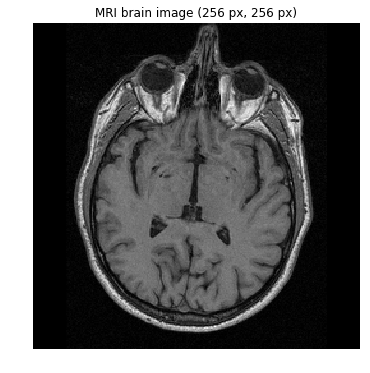

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing
Add your implementation and discussion

Region growing techniques start with one pixel of a potential region and try to grow it by adding adjacent pixels till the pixels being compared are too disimilar. 

To implement the region growing technique, I have defined two functions 'getneighborcoor' which finds a coordinates of the neighbor pixels and 'region_growing' which is the main function to do region growing. In the 'getneighborcoor' I defined neighbor pixels as the pixels in 8 other direction(right, left, top, bottom, topleft, topright, bottomright, bottomleft) around the current position. In the 'region_growing' function, there is a list of pixels that needs to be investigated and the labeling palette telling if the pixels are already investigated.  

In [3]:
def getneighborcoor(h, w, img):
    
    '''
    INPUT
        - x, y are the coordinate of the image that are currently interested in.
        - img is the original image that x,y are belonged.
    OUTPUT
        - list of coordinates of the neighbor pixels
    
    '''
    
    out = []
    
    (origin_h, origin_w) = img.shape
    origin_h = origin_h - 1
    origin_w = origin_w - 1

    #top left
    outh = min(max(h-1,0),origin_h)
    outw = min(max(w-1,0),origin_w)
    out.append((outh,outw))

    #top center
    outh = min(max(h-1,0),origin_h)
    outw = w 
    out.append((outh,outw))

    #top right
    outh = min(max(h-1,0),origin_h)
    outw = min(max(w+1,0),origin_w)
    out.append((outh,outw))

    
    #left
    outh = h
    outw = min(max(w-1,0),origin_w)
    out.append((outh,outw))

    #right
    outh = h
    outw = min(max(w+1,0),origin_w)
    out.append((outh,outw))

    
    #bottom left
    outh = min(max(h+1,0),origin_h)
    outw = min(max(w-1,0),origin_w)
    out.append((outh,outw))

    #bottom center
    outh = min(max(h+1,0),origin_h)
    outw = w
    out.append((outh,outw))

    #bottom right
    outh = min(max(h+1,0),origin_h)
    outw = min(max(w+1,0),origin_w)
    out.append((outh,outw))

    return out

In [4]:
def region_growing (image, seed, threshold,threshold2):
    '''
    Input 
        - image is the input image that you want to segment.
        - seed in tupple is the position of the image that will be the start of the segmentation. 
          (Usually choose point inside the segmentation.)
        - threshold is the difference between the values of the nieghbors
    Output
        - output is the image that segmented part is white and the other parts in black.
    
    ex> region_growing(my_img, (31,21),8)
    
    '''

    input_im = image.copy()
    
    # Define output piture and labeling place
    output = np.zeros_like(image)
    not_labeled = np.ones_like(image, dtype=bool) # is FALSE when labled
    
    onlist_coord = []    # list of coordinates that are worth to investigate
    
    onlist_coord.append(seed)
    start_pixel = input_im[onlist_coord[0]]
    print('The seed pixel value is {}'.format(start_pixel))

    while(len(onlist_coord) > 0):
        current_pixel = onlist_coord[0]
        output[current_pixel] = 255  
        not_labeled[current_pixel] = False
        #print(i, 'current pixel', current_pixel)
        for neighbors in getneighborcoor(current_pixel[0], current_pixel[1], input_im):
            if(not_labeled[neighbors]):
                
                # When investigated, label it to False
                not_labeled[neighbors] = False
                
                # When the neighbor pixel difference is smaller than threshold, append it on the list for investigation.
                if (np.abs(int(input_im[current_pixel]) - int(input_im[neighbors])) < threshold): 
                    onlist_coord.append(neighbors)
                else:
                    # When the neighbor pixels are not so different from the seed, consider it again. (fine tuning is needed)
                    if (np.abs(int(input_im[current_pixel]) - int(start_pixel)) < threshold2):
                        not_labeled[neighbors] = True
                        
        
        onlist_coord.pop(0)

        
    # Calculate the areas detected
    area = np.sum(output/255).astype(int) 
    print('In total {} pixels are counted'.format(area))
    return output    

When running the region growing technique, I should choose the starting seed carefully so that it is located inside the part that i want to find. There are two threshold values as inputs in my function one is for comparing the value differences between neighbors and the other one is for comparing the value differences with the seed pixel value. I have set the second thresholding part to reduce the non-counted part of the region. 

I choose the parameters of the input with fine tuning and I could get the best result with seed as (130,155), threshold value as 8 and threshold2 value as 14. The result of the region growing is shown below. I counted 15211 pixels for the brain region.

The seed pixel value is 82
In total 15211 pixels are counted


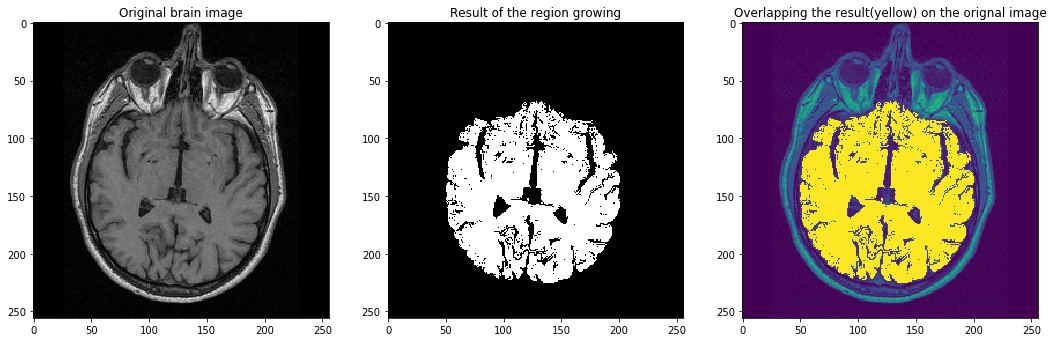

In [5]:
# DO the region growing 
result_region_growing = region_growing(brain_im, (130,155),8,14)
compare_im = brain_im | result_region_growing

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].set_title("Original brain image")
ax[0].imshow(brain_im, cmap='gray')

ax[1].set_title("Result of the region growing")
ax[1].imshow(result_region_growing, cmap='gray')

ax[2].set_title("Overlapping the result(yellow) on the orignal image")
ax[2].imshow(compare_im)

### 1.3 Contour detection
Add your implementation and discussion

The edges are defined as the points at which image brightness changes sharply and when it is connected to form closed boundary we call them contour. There are several ways to detect the edges of the images. One is to calculating the gradient magnitude, and then searching for local directional maxima of the gradient magnitude and Sobel, Prewitt and Roberts operators are the examples. The other way is detecting the zero-crossing in a second-order derivative expression computed from the image and Laplacian of Gaussian(LoG) is one of this examples. 

In this section, I am using sobel edge detection to detect the skull parts of the images and remove it from the whole image to get brain parts. I am detecting contours of the skull part of the images as this part is the ones that has more edges and contour than the brain part. 
Firstly, I blurred the original image to have better edge detection and then detected the edge with sobel operator. Then I did some thresholding on the edge values so that I only select the strong edges. By doing this, I could get the edges on the outer part of the brain since the pixel values inside the brain is more or less very similar so that there won't be many strong edges. 
Then I fill the image from the outer most contour to get the over-all head shapes and use this as backgraound template. Then I remove the skull part of the image from the first contour detection using this background template. After that I does some morphological operations such as dilation to strengthen brain part of the image. 
Finally, I do detect the contour of the image and select the largest contour part under assumption that brain is the largest part of the contour and then counted the contour area. 

The result of the contour detection of the brain is shown below.

0.01863190674858368


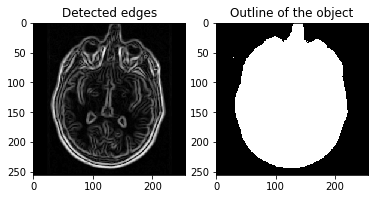

In [6]:
from skimage.filters import sobel

# Blur the image
blur_im = cv.blur(brain_im, (5,5))

# Do the edge detection using sobel operator
sobel_im = sobel(blur_im)
# Check the mean value of the edges detected to decide the threshold of the image.
print(sobel_im.mean())

# Threshold and do morphological operation(CLosing) to get the overall brain outerline. 
# (this is used to decide the background of the brain image)
ret, th_brain_im2 = cv.threshold(sobel(brain_im), 0.04 ,1, cv.THRESH_BINARY)
only_object = binary_fill_holes(th_brain_im2).astype(np.uint8)


fig, ax = plt.subplots(1, 2, figsize=(6, 6))
ax[0].set_title('Detected edges')
ax[0].imshow(sobel_im, cmap='gray')
ax[1].set_title('Outline of the object')
ax[1].imshow(only_object, cmap='gray')

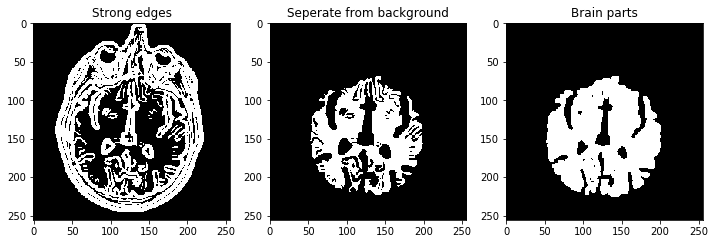

In [7]:
# Do the threshold on the edges to only detect strong edges which are skull part
ret, th_sobel_im = cv.threshold(sobel_im, 0.02 ,1, cv.THRESH_BINARY)

t = 1- th_sobel_im.astype(np.uint8)
# Seperate the background and remove the small objects which were part of the skulls.
no_bg_im = ( (1- th_sobel_im.astype(np.uint8)) & only_object)
rmnoise = morphology.remove_small_objects(no_bg_im.astype(bool), min_size=1000)

# Morphological operation(Dilate) on the brain part
kernel2 = np.ones((2,2),np.uint8)
brain_part = cv.morphologyEx(rmnoise.astype(np.uint8), cv.MORPH_DILATE,kernel2, iterations =3)

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].set_title('Strong edges')
ax[0].imshow(th_sobel_im, cmap='gray')
ax[1].set_title('Seperate from background')
ax[1].imshow(rmnoise,cmap='gray')
ax[2].set_title('Brain parts')
ax[2].imshow(brain_part,cmap='gray')

The largest contour area has  15651.0 number of pixels.


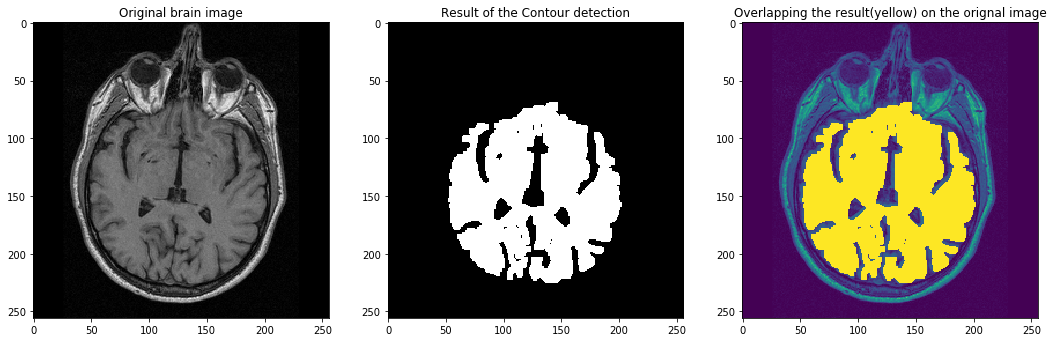

In [8]:
# Find contours from the image  and choose the biggest area
for_contour = brain_part.astype(np.uint8).copy()
contour_im, contours, hierarchy = cv.findContours(for_contour, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)

# Find the largest contour area 
area_bin =[]
for c in contours:
    area = cv.contourArea(c)
    area_bin.append(area)

# Find the contour index that has largest area
largest_ind = np.argmax(area_bin)

cnt = contours[largest_ind]
result_contour = cv.drawContours(contour_im, contours[largest_ind], 0, (0,255,0),0)
print('The largest contour area has ', area_bin[largest_ind], 'number of pixels.')

compare_im = brain_im | (result_contour*255)


# Visualize the result
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].set_title("Original brain image")
ax[0].imshow(brain_im, cmap='gray')

ax[1].set_title("Result of the Contour detection")
ax[1].imshow(contour_im, cmap='gray')

ax[2].set_title("Overlapping the result(yellow) on the orignal image")
ax[2].imshow(compare_im)

I fine tuned the parameter thresholding the detected edges to get the best result as possible. The result of the contour detection is shown above and the number of pixels counted from the brain part is 15651. 

Compared to the result of the region growing, more pixels were counted from the contour method. As we can see from the result, contour detection counted the most of the dark area on the bottom part of the brain. It was very difficult to detect the contour for each wrinkle of the brain so it does rough segmentation of the brain part. Thus, more pixels were counted by using contour detection method. 

The region growing method is more sensitive to each pixel value and its neighbors so that it will be useful when we are segmenting different objects which are separated by other kind of perceptual boundaries. On the other hand, contour detection method will be effective to segment different objects separated by edges where the areas of interests are isolated from the other part of the image. Depends on the image, one has to choose carefully which methods to use. However, still both region growing and contour detection method are effective methods to segment the object. 

### 1.4 Additional method(s)
Add your implementation and discussion

### Method 1

Since the color of the brain image differs by the parts of the brain, I tried thresholding to segment the only the brain part. 

The chosen location has pixel value of 112


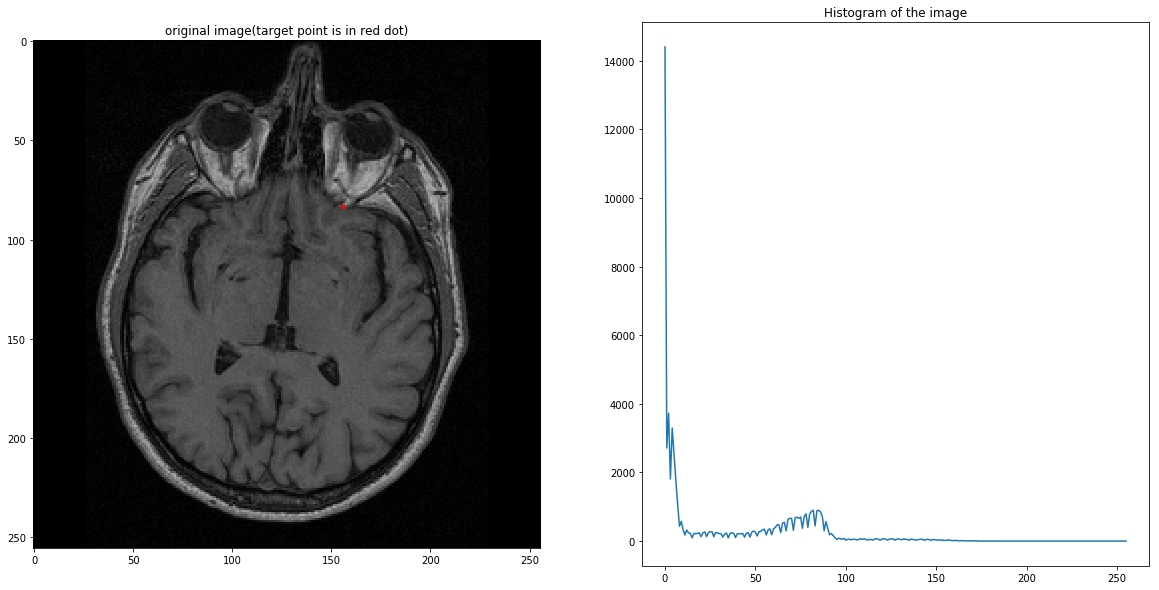

In [9]:
## Exploring pixel values 

# Choose the point inside the brain
target_point = (83,155)

# Draw the histogram of the image
hist_full = cv.calcHist([brain_im],[0],None,[256],[0,256])

# Print out the pixel value of the target point and draw its location on the image
print('The chosen location has pixel value of', brain_im[target_point])
copy_brain_im = cv.cvtColor(brain_im.copy(), cv.COLOR_GRAY2RGB)
copy_brain_im[target_point[0]:target_point[0]+2,target_point[1]:target_point[1]+2 ] = (255,0,0)


fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].set_title('original image(target point is in red dot)')
ax[0].imshow(copy_brain_im, cmap='gray')
ax[1].set_title('Histogram of the image')
ax[1].plot(hist_full)

Before executing threshold, I have explored the pixel values of the brain region from the origianl image to decide the thresholding value to make binary images. From the histogram above I could assume that the pixel values of the brain region are mostly above 60 and skull part is above 100.

Then I did morphological transformation to remove the skull part as much as possible. I assumed that brain is bigger than 2000 pixels so anything smaller than 2000 pixels will be removed.

The result of the method is given below. The number of pixels counted from the brain part is 15206.

The number of pixels counted as the brain are 15206


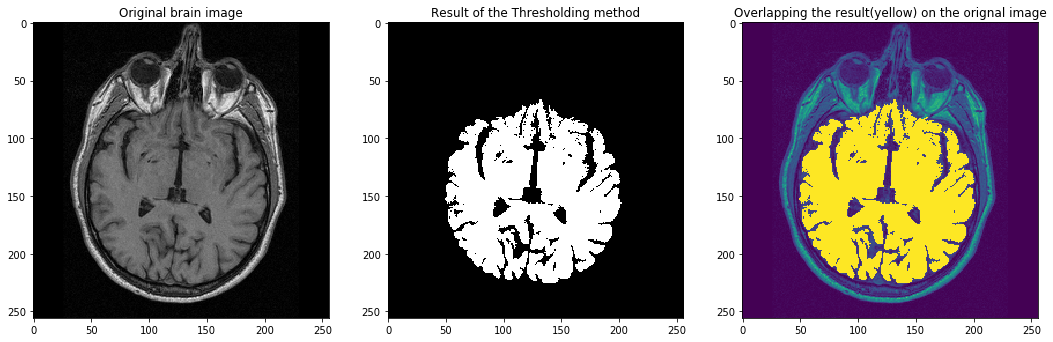

In [10]:
# For better accuracy, apply threshold to get binary image.
ret, rmskull_im = cv.threshold(brain_im, 100,1, cv.THRESH_TOZERO_INV)
ret, th_brain_im = cv.threshold(rmskull_im, 60,1, cv.THRESH_BINARY)

# Do Morphological process to seperate the brain from its skull
rmnoise_im = morphology.remove_small_objects(th_brain_im.astype(bool), min_size=2000)
result_thresh = rmnoise_im.astype(np.uint8)

#Count the area of the brain
print('The number of pixels counted as the brain are', np.sum(result_thresh))

compare_im = brain_im | (result_thresh*255)

# Visualize the result
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].set_title("Original brain image")
ax[0].imshow(brain_im, cmap='gray')

ax[1].set_title("Result of the Thresholding method")
ax[1].imshow(result_thresh, cmap='gray')

ax[2].set_title("Overlapping the result(yellow) on the orignal image")
ax[2].imshow(compare_im)

### Method 2

I tried using Scharr edge detector since it is less sensitive to the rotation of the images than Sobel. 

Similar to the contour detection method, I detected the edge of the skulls and remove the skull part from the image. Then this time without doing finding a contour, I blurred the image to remove small noises inside the brain part and then counted the pixels directly. 

The result of the method is given below. The number of pixels counted from the brain part is 15024.

0.034450836485809405
The number of pixels counted as the brain are 15024


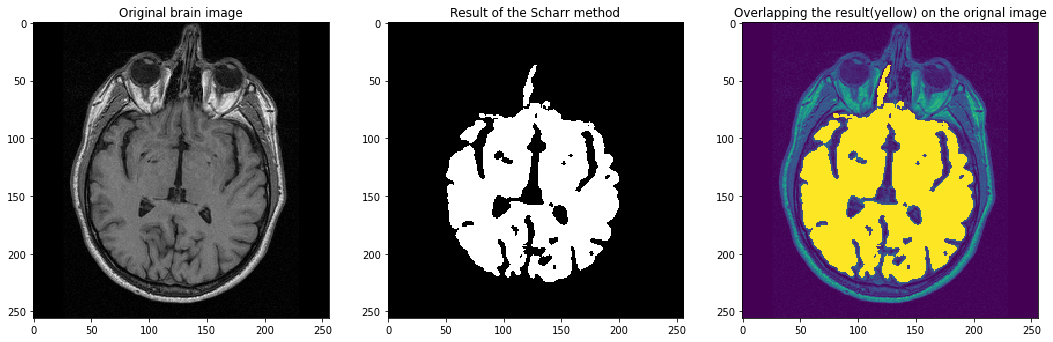

In [11]:
from skimage.filters import scharr

scharr_im = scharr(brain_im)
print(scharr_im.mean())
ret, th_scharr_im2 = cv.threshold(scharr_im, 0.05 ,1, cv.THRESH_BINARY)

rm_bg_im2 = ( (1- th_scharr_im2.astype(np.uint8)) &only_object)
rmskull = morphology.remove_small_objects(rm_bg_im2.astype(bool), min_size=500)

result_scharr = cv.blur(rmskull.astype(np.uint8), (5,5))


#Count the area of the brain
print('The number of pixels counted as the brain are', np.sum(result_scharr))

compare_im = brain_im | (result_scharr*255)

# Visualize the result
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].set_title("Original brain image")
ax[0].imshow(brain_im, cmap='gray')

ax[1].set_title("Result of the Scharr method")
ax[1].imshow(result_scharr, cmap='gray')

ax[2].set_title("Overlapping the result(yellow) on the orignal image")
ax[2].imshow(compare_im)

### Method 3

From the result that I have obtain from the previous method, I have created two makses in shape of a circle, one is encircling the brain and the other one having larger radius. This larger mask is created to ensure that all the brain parts are inside the circle when doing edge detection of the image on this masking area.  

I used Canny edge detection here and set the sigma value that detects enough edges inside the brain. I dilated those edges so that those who are very close to each other can be connected. Then I could fill the holes on the black regions inside the brain. Using the mask that fits the brain, I removed the outer parts of the brain.

The result of the method is given below. The number of pixels counted from the brain part is 15595.

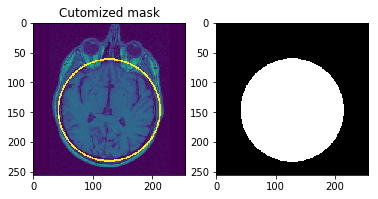

In [12]:
# Find the circle that encloses the brain
(x,y),radius = cv.minEnclosingCircle(cnt)
center = (int(x),int(y))
radius1 = int(radius)+5 # Increase the radius to make sure brain part inside the circle
radius2 = int(radius) # radius that fit the brain

# Draw circle 
blank = np.zeros_like(brain_im)
only_circle = cv.circle(blank.copy(),center,radius1,(255,255,255),2)
only_circle2 = cv.circle(blank.copy(),center,radius2,(255,255,255),2)

# Create a mask with the circle
custom_mask = binary_fill_holes(only_circle).astype(np.uint8)
brain_size_mask = binary_fill_holes(only_circle2).astype(np.uint8)

# Overlap the circle with brain image to check the mask
brain_in_circle = only_circle | brain_im

fig, ax = plt.subplots(1, 2, figsize=(6, 6))
ax[0].set_title("Brain image and the customized mask(yellow)")
ax[0].imshow(brain_in_circle)
ax[0].set_title("Cutomized mask")
ax[1].imshow(custom_mask,cmap='gray')


The number of pixels counted as the brain are 15595


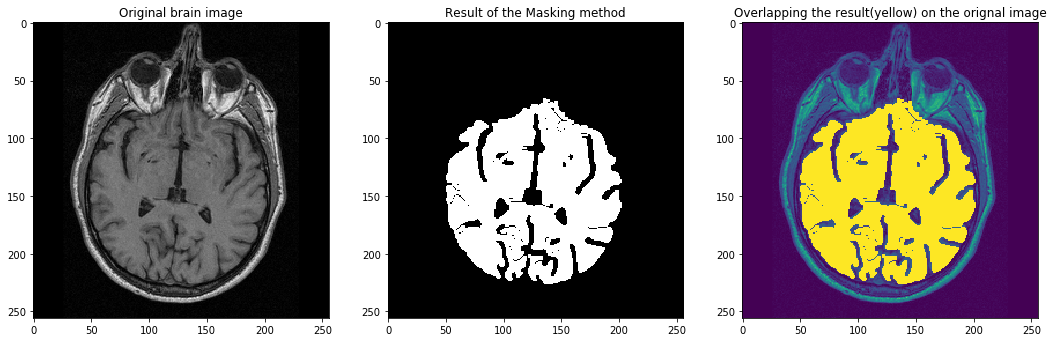

In [13]:
from skimage.feature import canny

# Detect the edges  within the mask(target area = brain)
canny_im = canny(brain_im, sigma=1.3, mask = custom_mask.astype(bool)).astype(np.uint8)

# Dilate the edges to connect edges close enough 
kernel = np.ones((2,2), np.uint8)
canny_edge = cv.morphologyEx(canny_im.astype(np.uint8), cv.MORPH_DILATE, kernel, iterations = 1)

# Fill the small holes inside the brain which are black parts and invert the image
fill_holes_im = 1 -  binary_fill_holes(canny_edge).astype(np.uint8)

# AND inverted image with brain sized circle
masked_im = fill_holes_im & brain_size_mask

# Remove small parts that are not belonging to the brain region
rmnoise = morphology.remove_small_objects(masked_im.astype(bool), min_size = 1300)

kernel2 = np.ones((2,3), np.uint8)
result_masking = cv.morphologyEx(rmnoise.astype(np.uint8), cv.MORPH_DILATE, kernel2, iterations = 1)


#Count the area of the brain
print('The number of pixels counted as the brain are', np.sum(result_masking))

compare_im = brain_im | (result_masking*255)

# Visualize the result
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].set_title("Original brain image")
ax[0].imshow(brain_im, cmap='gray')

ax[1].set_title("Result of the Masking method")
ax[1].imshow(result_masking, cmap='gray')

ax[2].set_title("Overlapping the result(yellow) on the orignal image")
ax[2].imshow(compare_im)

The results that I have got for additional methods are similar to each other and we can see from the visualized image that brain parts are well segmented. It was surprising that threshold method also works well. It was possible because the brain region's pixels were same or very similar. The result of the Scharr method was not much different from using Sobel(or a little worse). The masking method was very efficient to segment the area as I had priori knowledge of where the brain part is located. However, the maksing method will not work well if the image orientation changes. Lastly, when segmenting the image, morphology operations were extremely useful and it made the whole process much easier. 


## Part 2: Shape/color segmentation

You will find hereafter a picture of shapes of different colors, taken under four different illuminations.
We ask you to create a routine to:
1. Count the number of shapes of each color.
1. Compute the total area (in pixels) of each color.

One specific challenge is to be robust to illumination changes.
Try to have the same routine(s) running on the four images, and giving (approximatively) the same results.
Therefore some kind of intensity normalization should probably be used.
To help you, you will also find a reference image (palette) with disks of each possible color, that you can use as references.

**Note:** the routine(s) that you will write for this part will be useful for the robot project as well, so pay special attention to it.

### 2.1 Images and palette visualization

In [14]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03', 'arena-shapes-04']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  4
Image size: 480, 640 
Number of color channels:  3


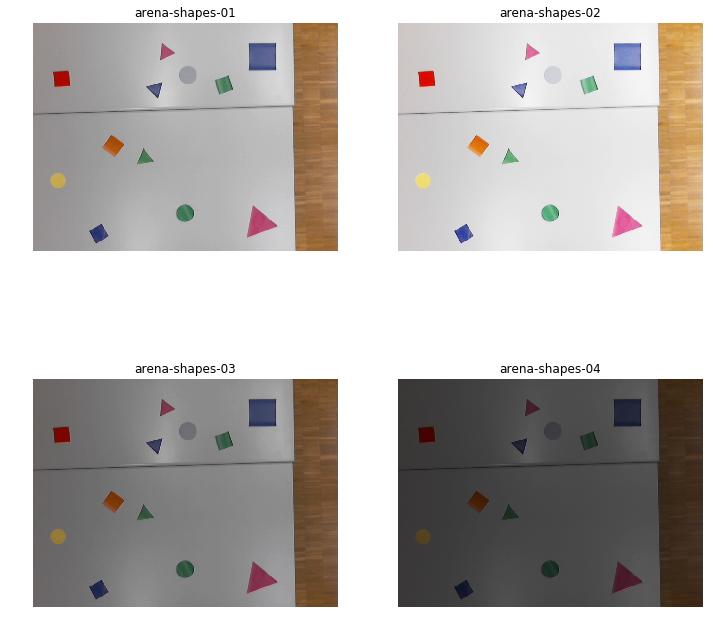

In [15]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

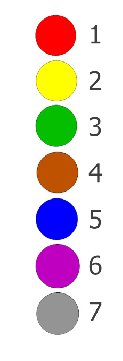

In [16]:
# Load and plot palette
palette = skimage.io.imread(os.path.join(data_path, 'arena-palette.png'))
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(palette)
ax.axis('off')
plt.show()

### 2.2 Number of shapes of each color
Add your implementation and discussion

First of all, I will use the HSV colormap for color detection since the given images has different brightness values. Then I would only have to consider Hue to detect the colors from different luminance. In Opencv, HSV colormap has a range from 0° to 180° for hue, 0 to 255 for saturation and 0 to 255 for values. 

I could decide the boundary of the colors that I need to detect the colors based from the HSV values I got for each colors in the palette. Here, I have set the Saturation and Value as 50 and 30 respectively for lower bound and 255 and 255 respectively for upper bound except for the gray color. Then I have set the boundary for Hue value of each color based from the Hue value information I retrieved from the palette. Additionally, I have set boundaries for some colors that does not exist in the palette. For instance, orange has hue boundaries from 10 to 15 since the hue values for red and brown that I've got from the palette was 0 and 13. Likewise, I have choosed the hue boundaries for pink as 140 to 180 as pink is the color in between red and violet. 

In [17]:
# Get the colors values from the palette
img = cv.imread(os.path.join(data_path, 'arena-palette.png'))
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
def get_colorsample(palette, numcolor):
    
    '''
    Input : image called with skimage
    
    output : value of the the colors in the palette
    '''
    height, width, rgb = palette.shape
    
    colorlist = []
    start_h = int(height/numcolor/2)
    
    for i in range(numcolor):
        value = palette[start_h, 40,:]
        colorlist.append(value)
        start_h += 88        
    
    return colorlist

# Print out the color values (in HSV) 
lis = get_colorsample(hsv,7)
lis

[array([  0, 255, 254], dtype=uint8),
 array([ 30, 255, 255], dtype=uint8),
 array([ 59, 255, 190], dtype=uint8),
 array([ 13, 255, 191], dtype=uint8),
 array([120, 255, 254], dtype=uint8),
 array([150, 255, 192], dtype=uint8),
 array([  0,   0, 148], dtype=uint8)]

In [18]:
# Set the boundary of the colors that I need 
lower_bound = {'red':(0, 50, 30), 'orange':(10, 50, 30),'yellow':(20, 50, 30), 
                 'green':(45, 50, 30), 'blue':(100, 50, 30), 'pink':(140, 50, 30), 'gray':(100,0,30)} 
upper_bound = {'red':(10,255,255),  'orange':(15,255,255), 'yellow':(45,255,255),
                 'green':(80,255,255), 'blue':(130,255,255),  'pink':(180, 255, 255), 'gray':(255,50,255)}

I also defined a function name 'detect_color' that give the the list of estimated color of the position on the image. Here the input image should be imported with the same package used for cheking the HSV values for the palette. This is due to that fact that different package has different range for colormaps. In the previous cell, I used the opencv for checking the HSV value of the image so that detect_color function should have input image imported by opencv. 

In case of multiple colors are detected, I calculate the distance from the pixel values to those colors and choose the closest one. When calculating the distance, I normalized the H,S,V values. 

In [19]:
# Detect the color of the selected position
def detect_color(position, source_image, lower, upper):
    '''
    INPUT : Position is the location of the pixel in (height, width)
            source_image is the input image that we want to process
            lower is the lower boundary of each colors (in dictionary format)
            upper is the upper boundary of each colors (in dictionary format)
    
    OUTPUT: Color of the position in list format (Ex. ['color'] )
    '''
    # Convert the color maps from RGB to HSV
    hsv_im = cv.cvtColor(source_image, cv.COLOR_BGR2HSV)

    # Create the color mask depends on the color key
    color_key = ['red','yellow','green','orange','blue','pink','gray']
    estimated_color = []
    for key in color_key:
        mask = cv.inRange(hsv_im, np.array(lower[key]), np.array(upper[key]))
        check = mask[position]
        if(check == 255): 
            estimated_color.append(key)
            
    # If more than two colors are detected, choose the one that are closer
    if(len(estimated_color) > 1):
        src_pixel = hsv_im[position]
        h1 = src_pixel[0]/180
        s1 = src_pixel[1]/255
        v1 = src_pixel[2]/255
        
        diff=[]
        for color in estimated_color:          
            color_value = (np.array(lower[color]) + np.array(upper[color])) /2
            h2 = color_value[0]/180
            s2 = color_value[1]/255
            v2 = color_value[2]/255
            
            # Calculate the distance
            #distance = np.abs(h1 - h2)
            distance = ( np.sin(h1)*s1*v1 - np.sin(h2)*s2*v2 )**2 + ( np.cos(h1)*s1*v1 - np.cos(h2)*s2*v2 )**2 + ( v1 - v2 )**2
            diff.append(distance)
        
        min_idx = np.argmin(diff)
        estimated_color = [estimated_color[min_idx]]

    # Return the color of the position
    return estimated_color

Next, I did some processing on the images so that it can detect the contour of the better. And defined this process as function 'preprocess_image'.

I first normalized the brightness of the image by converting the image to HSV color map. Then take the mean value of V and increase this value if the image is dark, and decrease this value if the image is bright by multiplying with different ratios. I tried not to normalize the brightness uiniformly as it can make the detection of the object worse. For example, when increasing the braightness of the dark image too much, the contrast of the image will get lost. After normalizing the brightness, I converted the image back to RGB color map then to the gray scale for the next step.

Then, I have used adaptiveThresholod function from opencv since the each images have different lighting conidition in different areas. This function calculate the threshold for a small region of the image so that we use different thresholds for different regions and it gives better result then fixed threshold. 

After thresholding images, I have done some morphology process such as closing on the thresholded image to remove small objects that is not the shape obeject I am looking for and dilation to fill the holes inside the objects. For closing process, I used the remove_small_objects function in the skimage. This function removes connected components smaller than the specified size where I set this size as 45. For dilation process, I used binary_fill_holes function from the scipy.ndimage. This function invades the only the shapesthat has connected outer boundary using binary dilation and eventually fill the holes of the objects with connected boundaries. 

In [20]:
# Preprocessing the images
def preprocess_image(input_image):
    
    # Check the luminance from HSV color map and normalize them
    hsv_input = cv.cvtColor(input_image,cv.COLOR_RGB2HSV)
    mean_v = hsv_input[:,:,2].mean() # Calculate the overal luminance of the input image
    
    # If the image is too bright, decrease the brightness
    if (mean_v > 130):
        hsv_input[:,:,2] = hsv_input[:,:,2] *0.9
    # If the image is too dark, increase the brightness
    else:
        hsv_input[:,:,2] = hsv_input[:,:,2] *1.3
    norm_hsv_input = cv.cvtColor(hsv_input,cv.COLOR_HSV2RGB)
    
    # Convert the normalized image into Gray Image
    gray_im = cv.cvtColor(norm_hsv_input,cv.COLOR_RGB2GRAY)
    
    # Threshold the gray image
    threshed_im= cv.adaptiveThreshold(gray_im,255,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,13,2)

    # Morphology process on the threshold image 
    # Remove small noises on the image
    inv_closed_im = ~threshed_im
    rmnoise_im = morphology.remove_small_objects(inv_closed_im.astype(bool), min_size=60)

    # Fill holes of the objects with closed boundaries
    clean_im = binary_fill_holes(rmnoise_im).astype(np.uint8)
    
    return clean_im


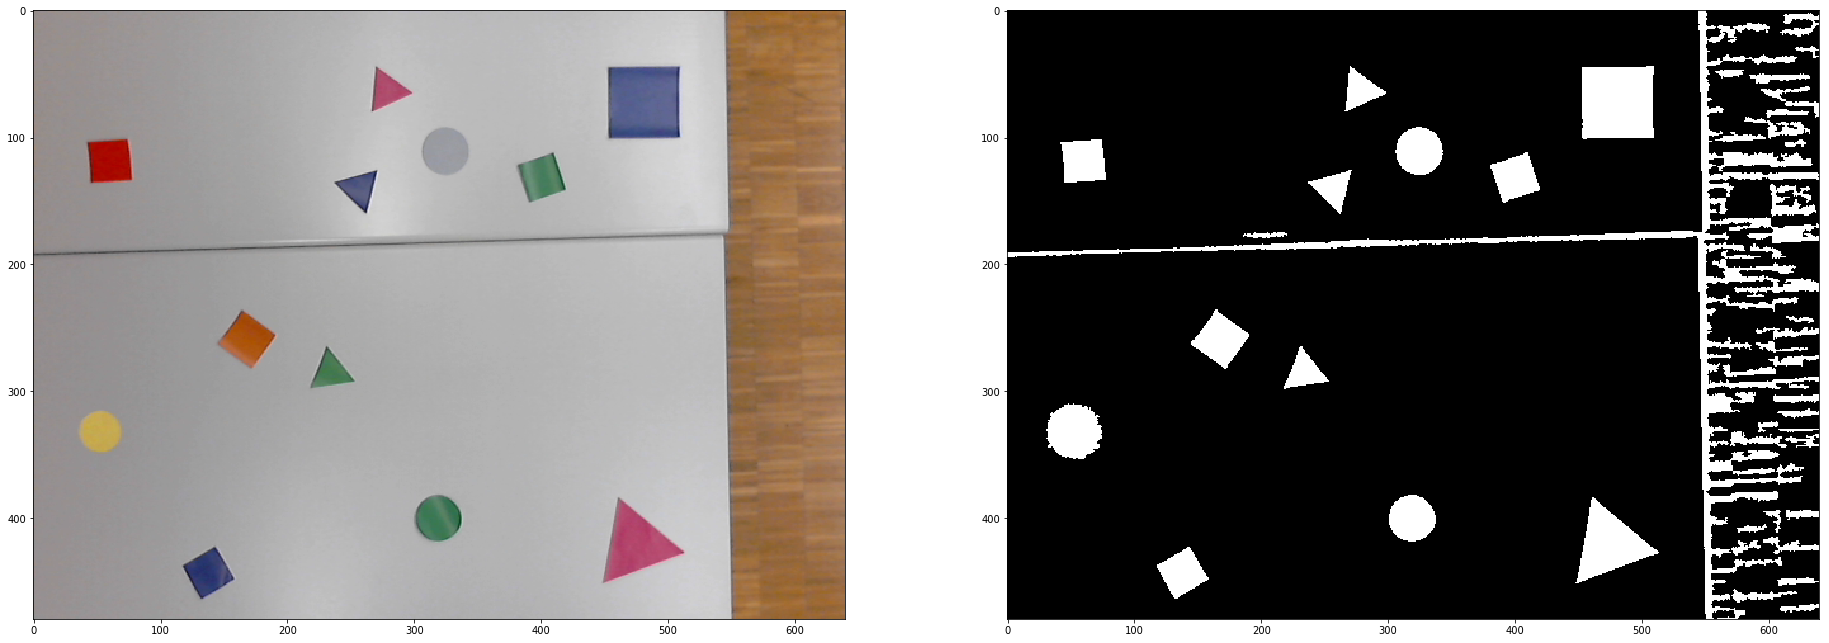

In [21]:
# Example of the preprocessing

# Choose the image.(i = 0,1,2,3)
i = 0

# Set the input image
original_im = images[i].copy()

# Preprocess the image
clean_im = preprocess_image(original_im)

# Visualize the result
fig, ax = plt.subplots(1, 2, figsize=(32,22))
ax[0].imshow(original_im, cmap='gray')
ax[1].imshow(clean_im,cmap='gray')


I also defined 'detect_shape_area' function to approximate the detected contours and to decide whether it is triangle, square or circle. It also calculates the area of the contours and give the size of the objects(in pixel).

In [22]:
# Detect the shape (Triangle, Square, Circle)
def detect_shape_area(c):
    '''
    INPUT : Contour of the object.
    
    OUTPUT: Shape of the object in a string
            Area(size) of the object
    '''
    # initialize the shape name and approximate the contour
    peri = cv.arcLength(c, True)
    approx = cv.approxPolyDP(c, 0.04 * peri, True)
    area = cv.contourArea(c)
    
    # If there are 3 vertices, the shape is Triangle
    if len(approx) == 3:
        shape = "triangle"
        
    # If there are 4 vertices, the shape is Square
    elif len(approx) == 4:
        shape = "square"
        
    # Otherwise, we assume the shape is circle
    else:
        shape = "circle"
        
    # Return the name of the shape an its size
    return shape, area

Finally, I will do contour detection from the preprocessed image using findcontours function from opencv. I used the RETR_LIST to have all the contours without hierachy and thus I can check through every single of them. For all the contours detected, I checked the center point of each contour and used that position for detecting the color of the object. Additionally, shape and area of the contours are also calculated. Finally, only the object which has the size in between the area thresholds(small_area, large_area) will be considered. This final step is made into one block as 'do_detection' function. 

In [23]:
def do_detection(img_name, which_color, small_area, large_area, with_area, print_info ):
    
    '''
        INPUTS : image_name is the name of the images that we want to detect. (Ex. 'arena-shapes-0x.png')
                 which_color is the specific colors that we want to detect. (Ex. ['blue', 'red'])
                 with_area is the flag that prints out the information about the area of the detected objects.(True or False)
                 pritn_info is the flag that decides the print of the information. (True or False)
                 small_area is the smallest size of the obeject.
                 large_area is the largest size of the obeject.
                 
        OUTPUT : Viusalization of the input and the detection.
                 Result of the detection if 'print_info' is True.
    '''
    print('\n <<<  Processing on  ', img_name,'>>>')
    
    image_set = {'arena-shapes-01.png':images[0], 'arena-shapes-02.png':images[1], 
                 'arena-shapes-03.png':images[2], 'arena-shapes-04.png':images[3]}

    # Import the images in opencv
    src_im = cv.imread(os.path.join(data_path, img_name))
    contour_im = image_set[img_name].copy() # copy the image for the contour visualization

    # Do preprocessing on the image
    clean_im = preprocess_image(image_set[img_name])

    # Find the contour of the objects
    im, contours, hierarchy = cv.findContours(clean_im,cv.RETR_LIST,cv.CHAIN_APPROX_SIMPLE)
    print('Number of objects detected are', len(contours))

    count_shape = {'red':0,'blue':0,'yellow':0,'green':0,'orange':0,'pink':0,'gray':0}
    count_area = {'red':0,'blue':0,'yellow':0,'green':0,'orange':0,'pink':0,'gray':0}
    each_color_shape = {'red':[],'blue':[],'yellow':[],'green':[],'orange':[],'pink':[],'gray':[]}
    count_obj = 0
    
    # Check the contours
    for c in contours:

        # compute the center of the contour
        M = cv.moments(c)
        ratio = src_im.shape[0] / float(src_im.shape[0])
        c_width = int((M["m10"] / M["m00"]) * ratio)
        c_height = int((M["m01"] / M["m00"]) * ratio)
        center_position = (c_height,c_width)

        # detect the colors of the contour
        color = detect_color(center_position, src_im, lower_bound, upper_bound)

        # Detect the shape of the contour and its area
        shape, area = detect_shape_area(c)

        # Only consider the shape that is within certain size 
        if (small_area<area<large_area):
            # Count the number of object in interest
            count_obj = count_obj +1
            
            # Count the shapes and its area
            for element in color:
                count_shape[element] +=1
                count_area[element] +=area 


            # Check if the detected color matches with what we want to detect
            if(any(i in color for i in which_color)):
                # Add the info of the shape of the color
                each_color_shape[color[0]].append(shape)

                # Draw the contours with the name of the shape on the image
                info = color[0] +' '+ shape    
                cv.drawContours(contour_im, [c], 0, (150, 255, 150), 3)
                cv.putText(contour_im, info, (c_width, c_height), cv.FONT_HERSHEY_DUPLEX, 0.6, (255, 255, 255), 2)

                # Add information about the area if the with_area flag is true
                if (with_area == True):
                    info2 = ' (' + (str(area)) + ')'
                    cv.putText(contour_im, info2, (c_width, c_height+22), cv.FONT_HERSHEY_DUPLEX, 0.6, (255, 255, 255), 2)

    
    # Print out the information if the flag is true
    if (print_info == True):
        print('Number of objects in interests are', count_obj)
        print('Counting the shapes of each colors: ',count_shape)
        print('For particular colors that you choosed ...')
        for key in which_color:
            print('-- ', key.upper(), 'has the shapes of ', each_color_shape[key])

        if (with_area == True):
            print('Counting the total areas of each colors: \n',count_area)

    # Visualize the result of the detection
    fig, ax = plt.subplots(1, 2, figsize=(32,22))
    ax[0].imshow(image_set[img_name])
    ax[0].set_title(img_name)
    ax[1].imshow(contour_im)
    ax[1].set_title('Visualizing the detection')

### Result of the number of shapes of each color. 


 <<<  Processing on   arena-shapes-01.png >>>
Number of objects detected are 44
Number of objects in interests are 12
Counting the shapes of each colors:  {'red': 1, 'blue': 3, 'yellow': 1, 'green': 3, 'orange': 1, 'pink': 2, 'gray': 1}
For particular colors that you choosed ...
--  PINK has the shapes of  ['triangle', 'triangle']
--  RED has the shapes of  ['square']

 <<<  Processing on   arena-shapes-02.png >>>
Number of objects detected are 38
Number of objects in interests are 12
Counting the shapes of each colors:  {'red': 1, 'blue': 3, 'yellow': 1, 'green': 3, 'orange': 1, 'pink': 2, 'gray': 1}
For particular colors that you choosed ...
--  BLUE has the shapes of  ['square', 'triangle', 'square']
--  GREEN has the shapes of  ['circle', 'triangle', 'square']
--  GRAY has the shapes of  ['circle']

 <<<  Processing on   arena-shapes-03.png >>>
Number of objects detected are 38
Number of objects in interests are 12
Counting the shapes of each colors:  {'red': 1, 'blue': 3, 'yellow

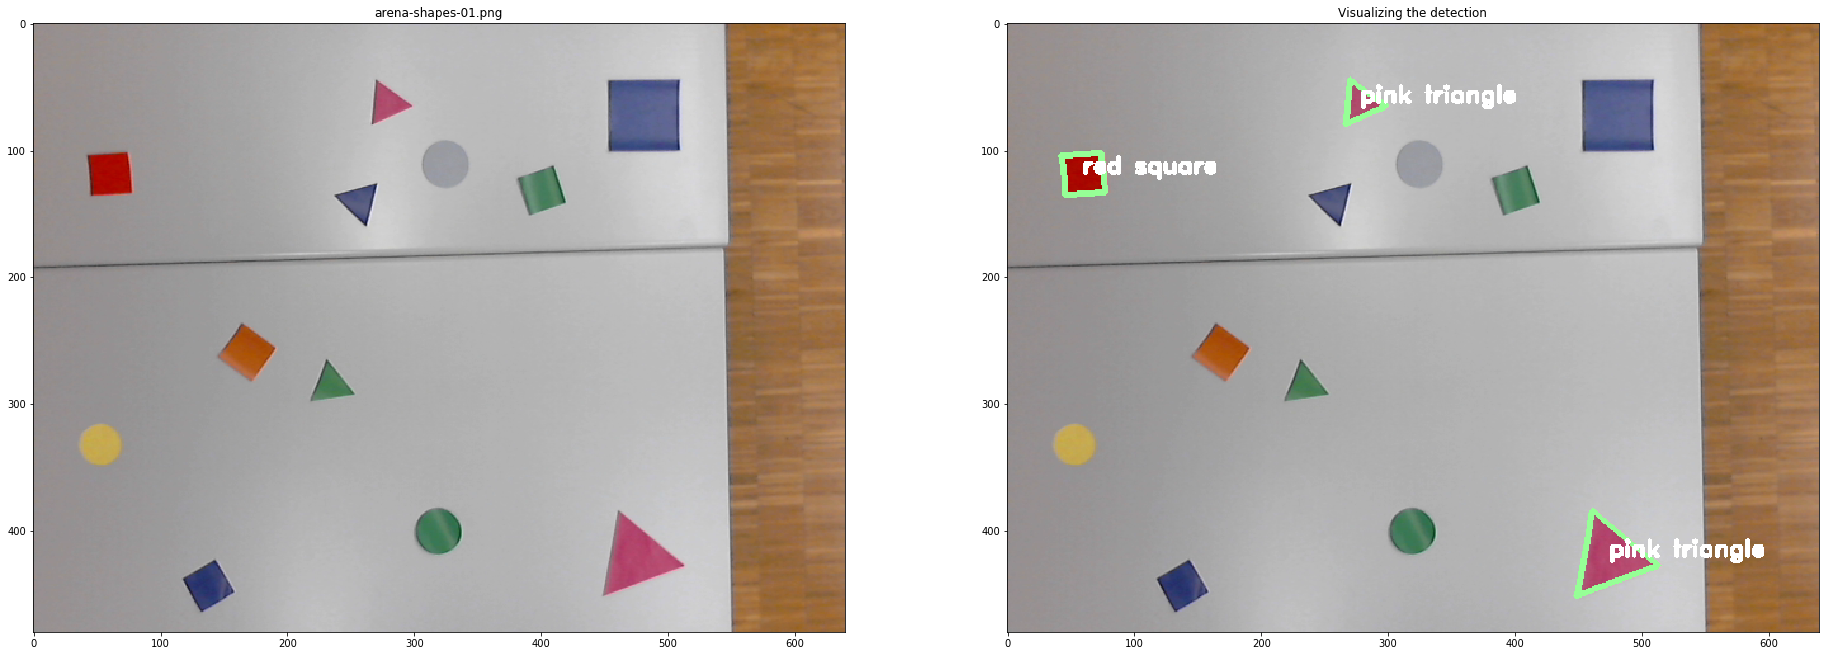

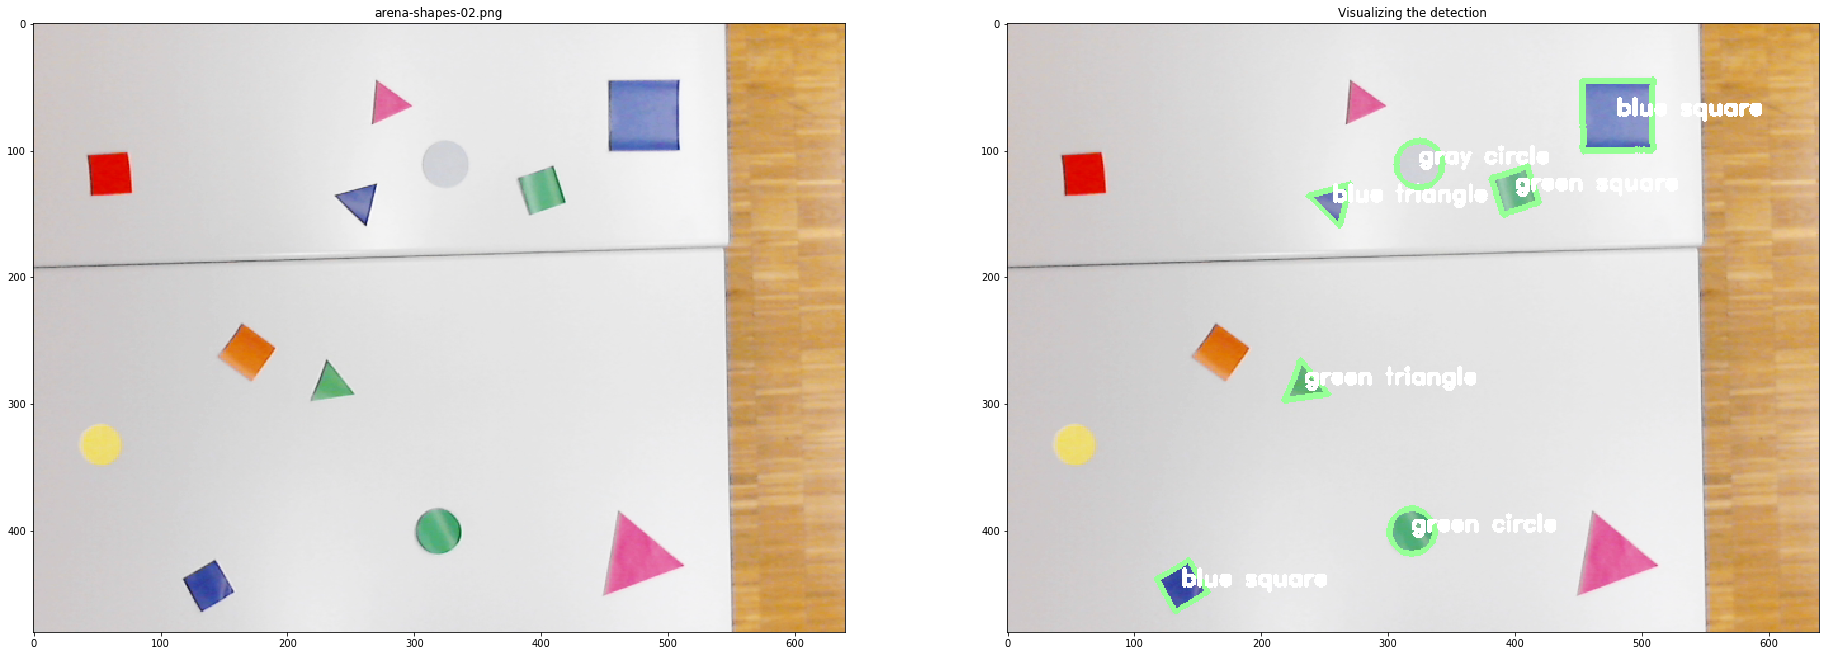

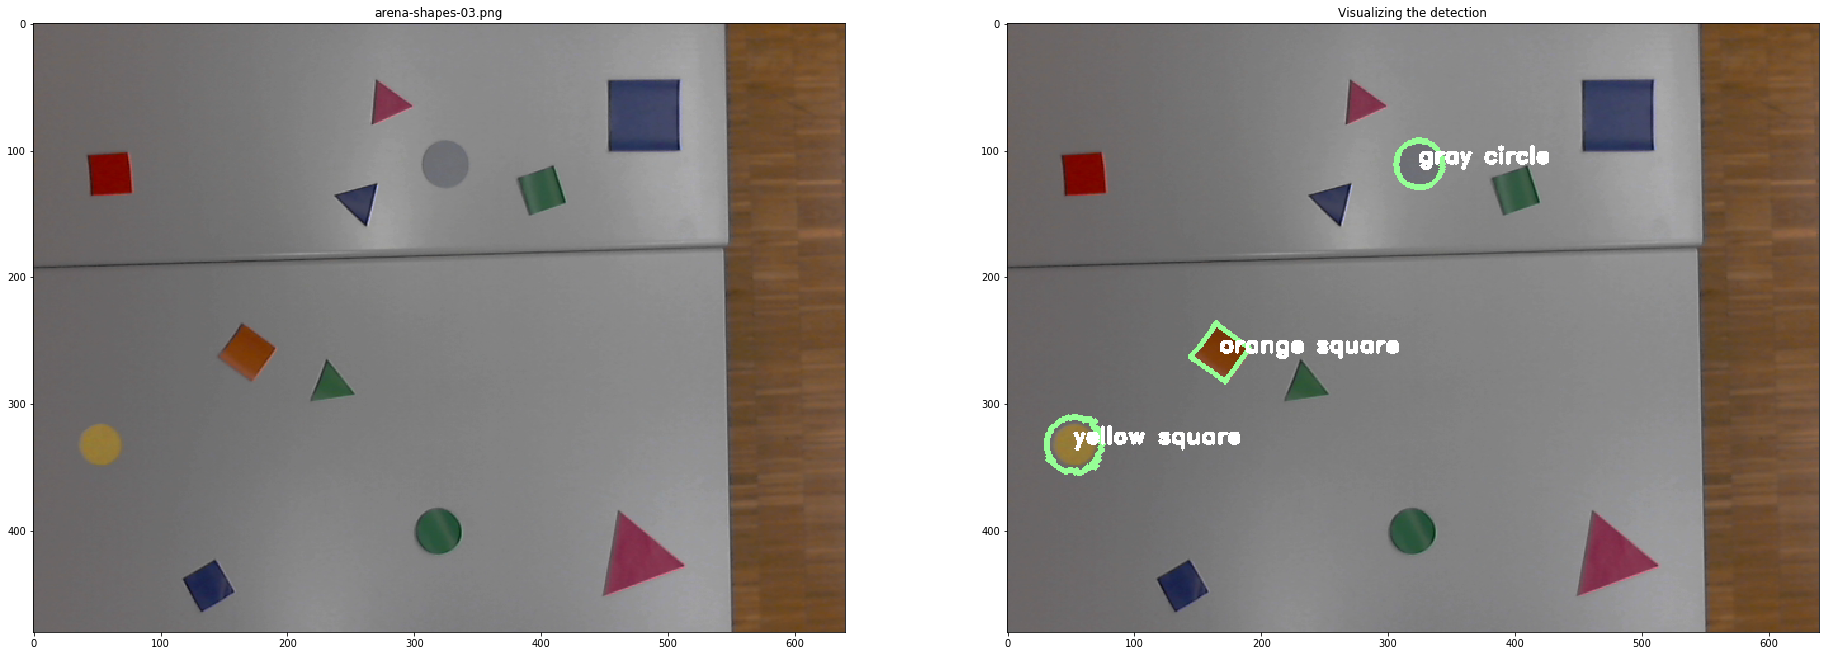

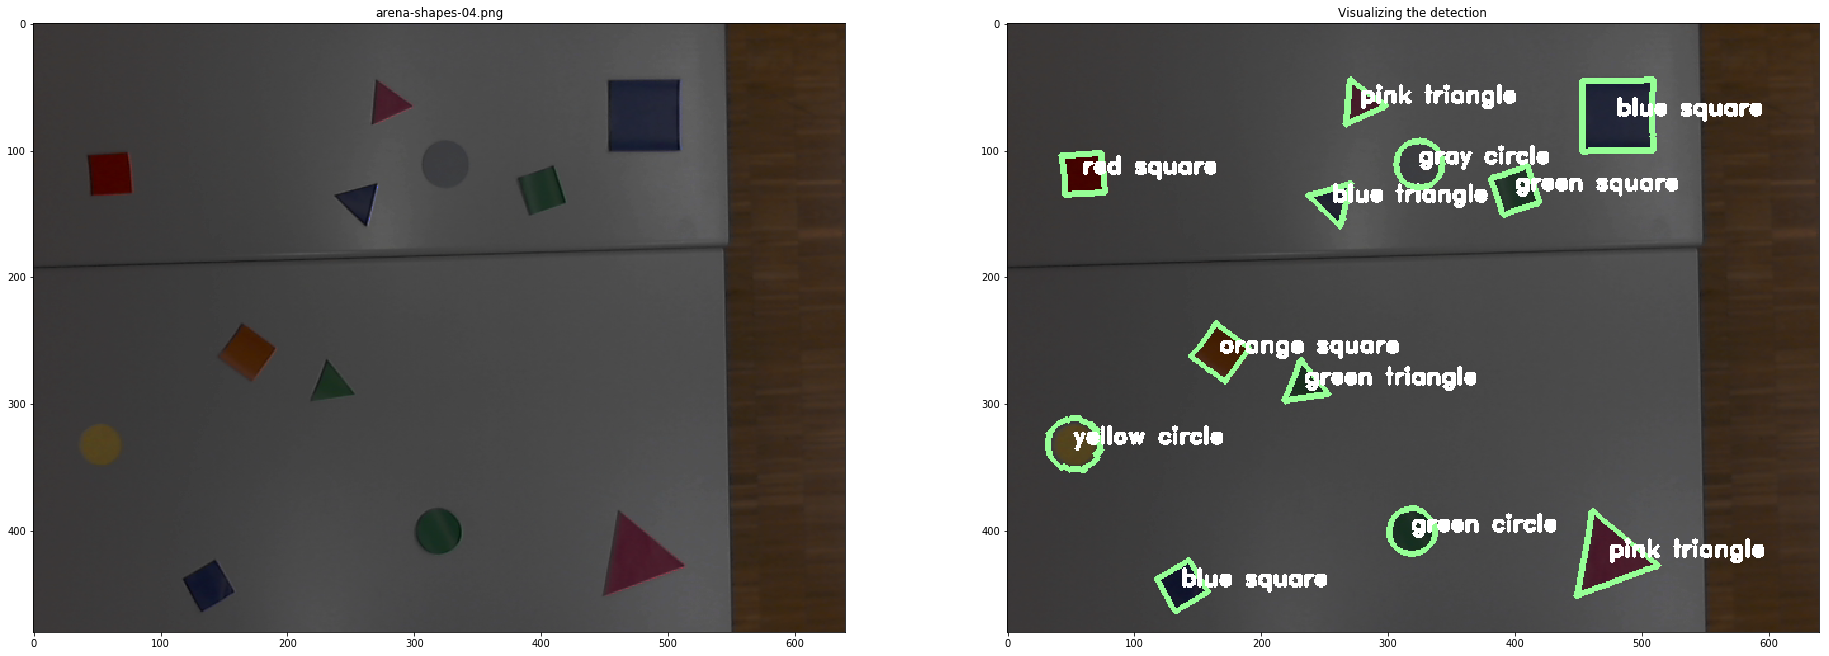

In [24]:
# Run the detection for each images.
all_colors = ['red','yellow','green','orange','blue','pink','gray']
do_detection('arena-shapes-01.png',['pink','red'] , 450,3500, False, True)
do_detection('arena-shapes-02.png',['blue','green','gray'] ,  450,3500,False, True)
do_detection('arena-shapes-03.png',['yellow','gray','orange'] ,  450,3500,False, True)
do_detection('arena-shapes-04.png',all_colors ,  450,3500,False, True)

For all the images I could count the shape for each colors. The result was same for all images. 
- {'red': 1, 'blue': 3, 'yellow': 1, 'green': 3, 'orange': 1, 'pink': 2, 'gray': 1}


### 2.3 Total area (in pixels) of each color
Add your implementation and discussion

Here, all the process is ths same as the previous steps so I just run 'do_detection' with 'with_area' = True. This will give us the information of the areas of the each colors. 

### Result of the total area of each color. 


 <<<  Processing on   arena-shapes-01.png >>>
Number of objects detected are 44
Number of objects in interests are 12
Counting the shapes of each colors:  {'red': 1, 'blue': 3, 'yellow': 1, 'green': 3, 'orange': 1, 'pink': 2, 'gray': 1}
For particular colors that you choosed ...
--  YELLOW has the shapes of  ['circle']
--  GREEN has the shapes of  ['circle', 'triangle', 'square']
Counting the total areas of each colors: 
 {'red': 975.0, 'blue': 4435.5, 'yellow': 1399.0, 'green': 2443.0, 'orange': 1064.5, 'pink': 2500.0, 'gray': 1051.5}

 <<<  Processing on   arena-shapes-02.png >>>
Number of objects detected are 38
Number of objects in interests are 12
Counting the shapes of each colors:  {'red': 1, 'blue': 3, 'yellow': 1, 'green': 3, 'orange': 1, 'pink': 2, 'gray': 1}
For particular colors that you choosed ...
--  RED has the shapes of  ['square']
--  YELLOW has the shapes of  ['circle']
--  GREEN has the shapes of  ['circle', 'triangle', 'square']
--  ORANGE has the shapes of  ['squ

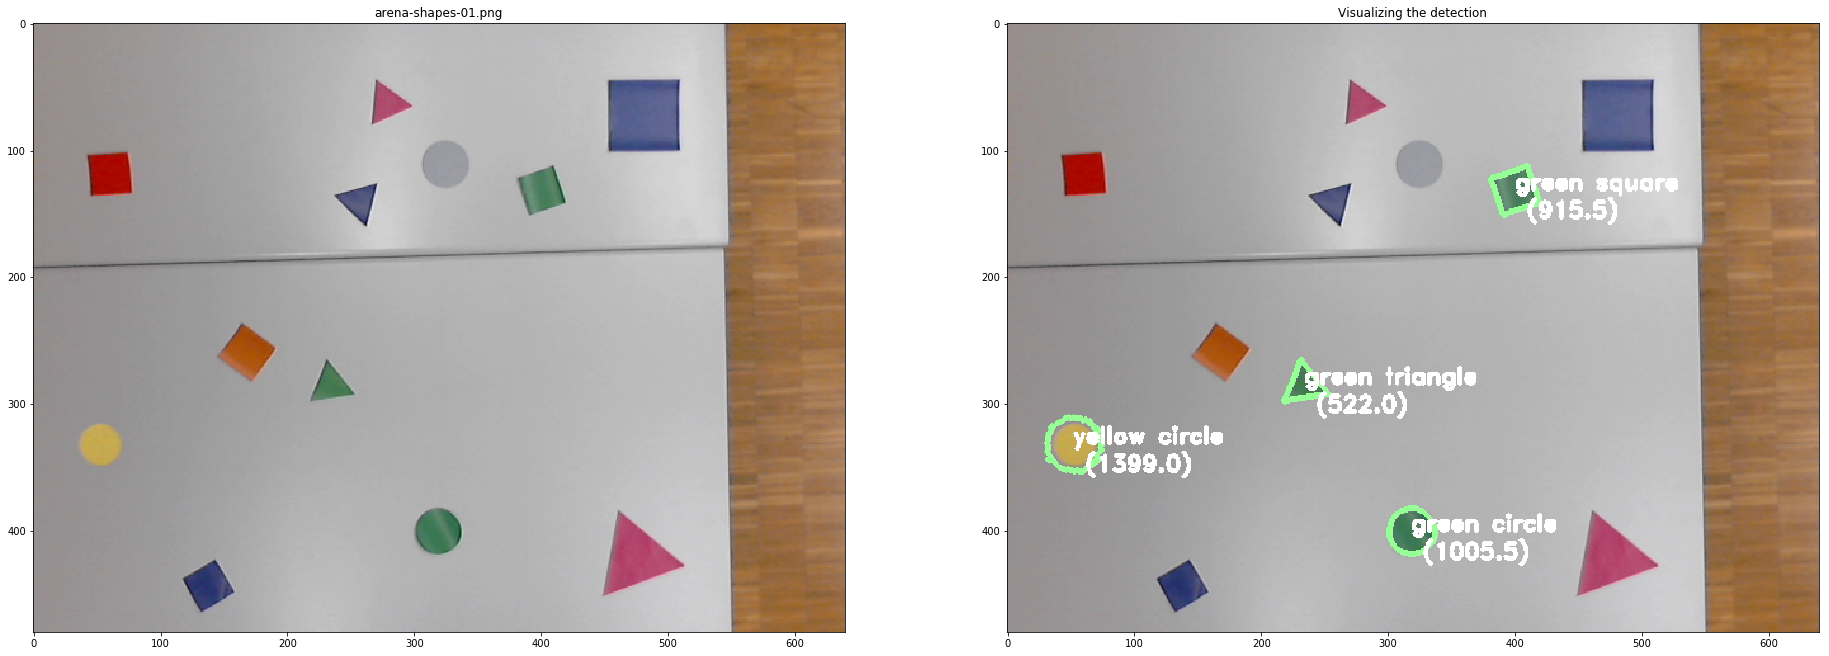

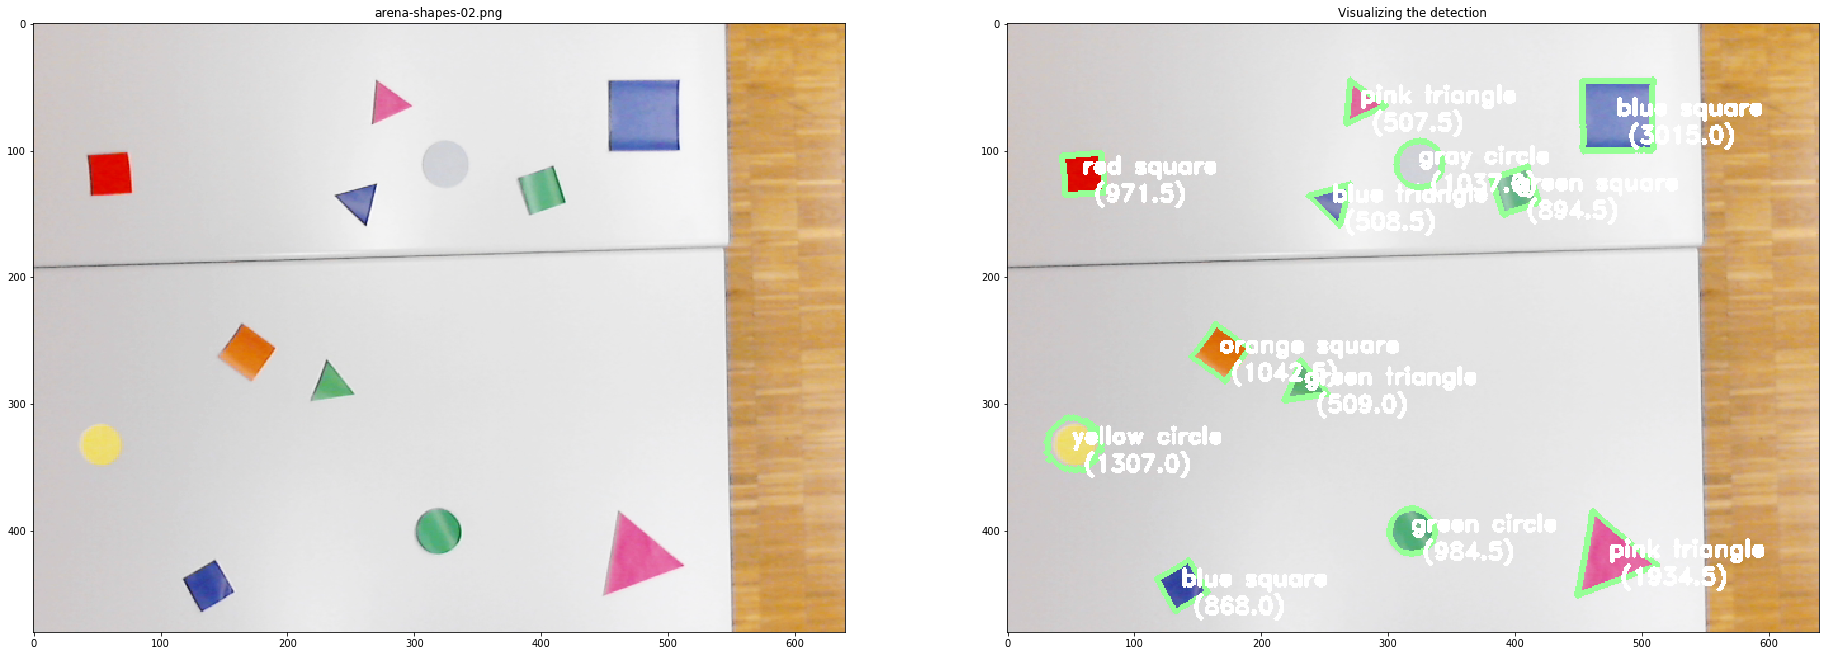

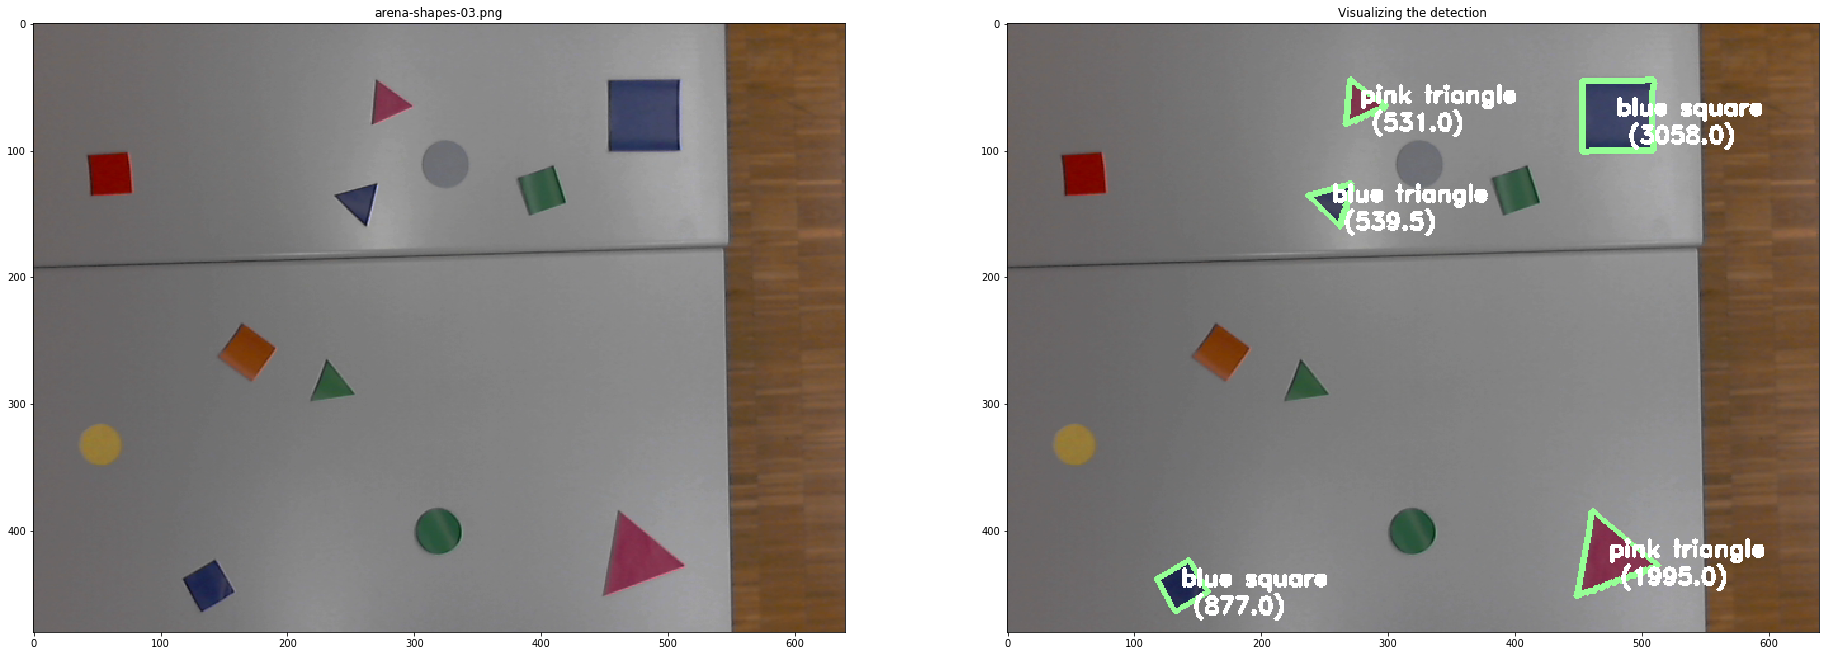

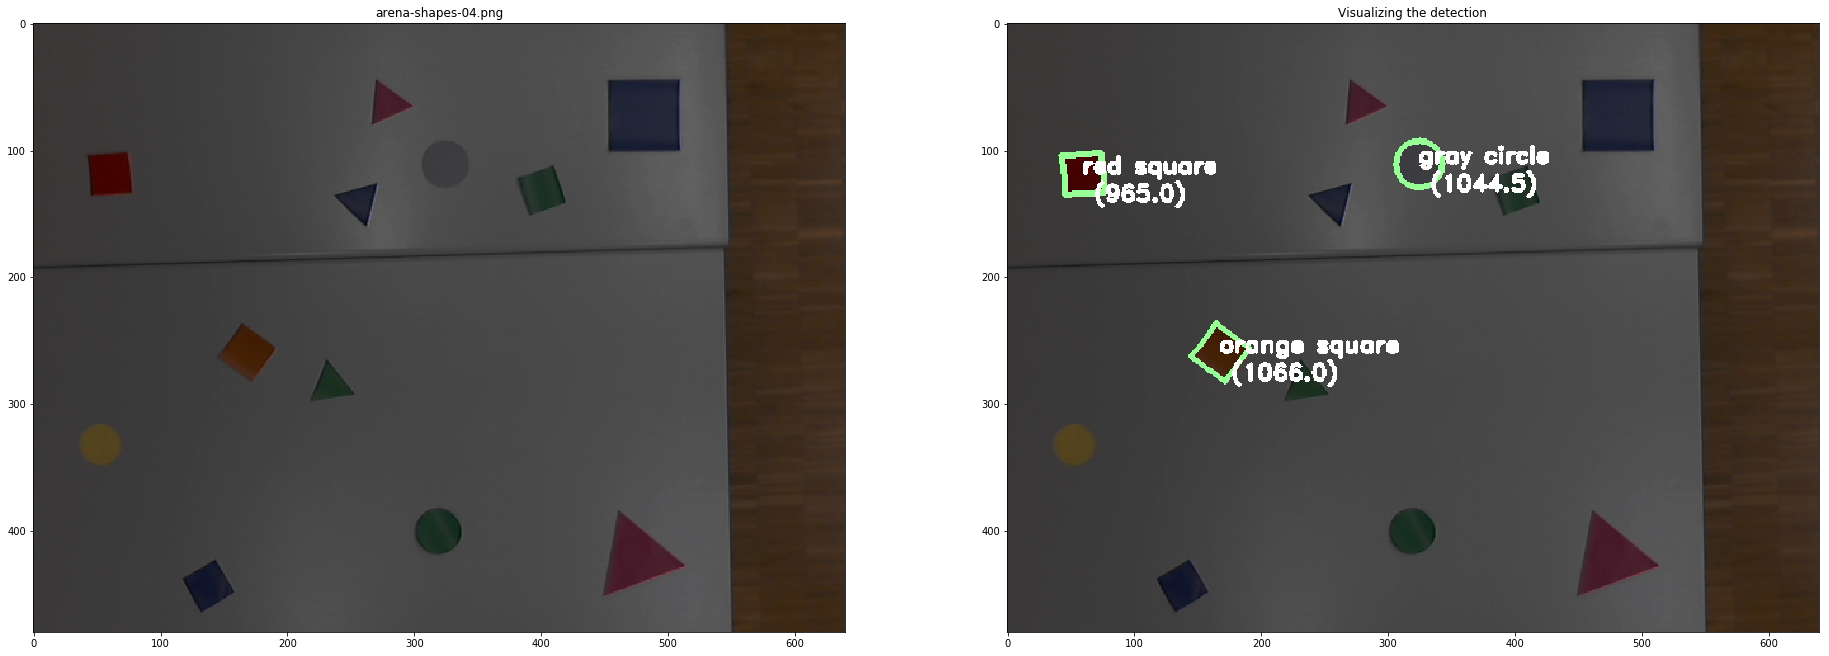

In [25]:
# Run the detection for each images.
all_colors = ['red','yellow','green','orange','blue','pink','gray']
do_detection('arena-shapes-01.png',['yellow','green'] ,  450,3500,True, True)
do_detection('arena-shapes-02.png',all_colors ,  450,3500,True, True)
do_detection('arena-shapes-03.png',['blue','pink'] ,  450,3500,True, True)
do_detection('arena-shapes-04.png',['red','gray','orange'] ,  450,3500,True, True)

As we can see from the result, the total areas counted for all images are pretty much similar to each other. 
- First image : {'red': 975.0, 'blue': 4435.5, 'yellow': 1399.0, 'green': 2443.0, 'orange': 1064.5, 'pink': 2500.0, 'gray': 1051.5}
- Second image : {'red': 971.5, 'blue': 4391.5, 'yellow': 1307.0, 'green': 2388.0, 'orange': 1042.5, 'pink': 2442.0, 'gray': 1037.0}
- Third image :  {'red': 970.0, 'blue': 4474.5, 'yellow': 1459.5, 'green': 2460.0, 'orange': 1069.5, 'pink': 2526.0, 'gray': 1056.5}
- Fourth image : {'red': 965.0, 'blue': 4461.0, 'yellow': 1297.5, 'green': 2448.5, 'orange': 1066.0, 'pink': 2509.5, 'gray': 1044.5}


It looks like algorithm works well for all the images provides. Still there exists some parts that can be improved. 
1. It would be better if I can automatically set the boundaries from the palette for each colors. However the colors in the palette does not exsist in the image so setting the boundaries manually was the best I could do. 
2. When there are differnt types of shape occurs, 'detect_shape_area' function should be updated too.

Nevertheless, the detection process using HSV colormap was successful to detect colors from images provided for this exercise with different brightness. 